# DataCamp Certification Case Study

### Project Brief

Congratulations, you have just landed your first job as a data scientist at Snow Cone Games! Snow Cone Games are a digital retailer for video games. For your first assignment, you will be working with the product manager to find new ways to categorize games on their homepage. 

She has recently learned that only 23% of buyers search for games using the genre filter (e.g., action, sports, etc). 71% of buyers use advanced filters to find the types of games that appeal to them. She hopes that creative new categories based on different game attributes can help players find what they are looking for faster.

You have a dataset containing the Snow Cone Games’ library of over 40,000 video games. The product manager would like to see if you can group the data into categories that make sense. She has also told you that she wants to avoid more than five categories if possible, as any more would be difficult to fit into the platform homepage. 

You will need to present your findings in two formats:
- You must submit a written report summarising your analysis to your manager. As a data science manager, your manager has a strong technical background and wants to understand what you have done and why. 
- You will then need to share your findings with the product manager in a 10 minute presentation. The product manager has no data science background but is familiar with basic data related terminology. 

The data you will use for this analysis can be accessed here: `"data/video_games.csv"`

### 0. Frame the problem and look at the Big Picture
1. This problem looks to improve the user experience by giving a faster way to find out what they are looking for using categories. We have to find 5 categories in order to do that.
2. We are facing to a *supervised problem* because we are given labeled data.
3. It is *multivariate* because we are predicting multiple variables.
4. It is *classification* because we are predicting classes.
5. Performance should be measured by confussion matrix, false positive & false negative, accuracy, precission, recall and F-1 score. We can try ROC and AUC.

## 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Configure visualizations
plt.rcParams['figure.figsize'] = [8, 4]
sns.set_theme(style='darkgrid')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### 2. Import and Inspect the data

In [2]:
# Present working directory
pwd = os.getcwd()
filepath = os.path.join(pwd,"data/video_games.csv")
filepath

'g:\\Mi unidad\\Data Science & Data Analyst\\Projects\\Datacamp\\Certification - Video Game Categories\\data/video_games.csv'

In [3]:
# Creating a dataframe with the CSV in it.
df = pd.read_csv(filepath, parse_dates=["release_date"], cache_dates=True)

# Preview the data
df

C:\Users\Luis Andres\miniconda3\lib\site-packages\pandas\io\parsers\base_parser.py:1070: UserWarning: Parsing '20/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  return tools.to_datetime(


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
0,DOOM,"May 12, 2016",id Software,54.0,$19.99,92%,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,$29.99,49%,836608.0,True,True
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,$39.99,71%,7030.0,True,False
3,DayZ,"Dec 13, 2018",Bohemia Interactive,NaN,$44.99,61%,167115.0,True,False
4,EVE Online,"May 6, 2003",CCP,NaN,Free,74%,11481.0,True,False
...,...,...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,"Feb 12, 2019",Ubisoft - San Francisco,NaN,$2.99,NaN,NaN,False,False
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,"Feb 5, 2019",Ubisoft - San Francisco,NaN,$2.99,NaN,NaN,False,False
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,"Jul 31, 2018","SmiteWorks USA, LLC",NaN,$7.99,NaN,NaN,True,False
40831,Mega Man X5 Sound Collection,"Jul 24, 2018","CAPCOM CO., LTD",NaN,$9.99,NaN,NaN,False,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40833 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              40817 non-null  object 
 1   release_date      37654 non-null  object 
 2   developer         40490 non-null  object 
 3   achievements      12194 non-null  float64
 4   original_price    35522 non-null  object 
 5   percent_positive  17363 non-null  object 
 6   num_reviews       17363 non-null  float64
 7   multiplayer       40313 non-null  object 
 8   mature            40833 non-null  bool   
dtypes: bool(1), float64(2), object(6)
memory usage: 2.5+ MB


From info() we can say we've got a 40833. There are missing values.

Lets have a look individualy each column:
* name
* release_date: to datetime. Pandas see it as an object
* developer
* achievement: number of achievements players can earn, is this important? just 1/4 data available.
* original_price: price is not float. Convert "Free" as 0$?
* percent_positive: convert to int
* num_reviews: we can split this in 3-4 categories.
* multiplayer: convert to bool.
* mature

In [5]:
df.isnull().sum()

name                   16
release_date         3179
developer             343
achievements        28639
original_price       5311
percent_positive    23470
num_reviews         23470
multiplayer           520
mature                  0
dtype: int64

In [6]:
# We can drop nan from "name"
df[df["name"].isna()]

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
704,NaN,NaN,NaN,NaN,$29.99,NaN,NaN,NaN,False
4847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
6381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
7869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9615,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
9956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
12879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
23099,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [7]:
# original_price needs a deeper clean
df['original_price'].value_counts()

$4.99                    4123
$9.99                    3903
$0.99                    3569
$2.99                    3371
$1.99                    2764
                         ... 
$289.99                     1
Sanguine Sanctum Demo       1
$5.56                       1
$16.88                      1
$1.09                       1
Name: original_price, Length: 681, dtype: int64

In [8]:
df['achievements'].value_counts()

10.0      513
12.0      484
20.0      451
15.0      380
13.0      359
         ... 
4013.0      1
148.0       1
4732.0      1
408.0       1
333.0       1
Name: achievements, Length: 360, dtype: int64

In [9]:
df['multiplayer'].value_counts()

False    29233
True     11080
Name: multiplayer, dtype: int64

In [10]:
df['percent_positive'].value_counts()

100%    722
90%     594
92%     510
88%     475
80%     474
       ... 
6%        4
5%        4
4%        2
3%        2
2%        1
Name: percent_positive, Length: 100, dtype: int64

### 3. Data Cleaning

Assumptions:
1. name: nulls drop, no info in it
2. developer: if null, "Other" developer
3. achievements: if null, 0 achievements
4. original_price: clean. if null, free = 0$
5. num_reviews: if null, no reviews so 0 reviews.
6. multiplayer: if null, no multiplayer, so False
7. percent_positive: clean, if null, 0%
8. release_date: keeping just the year release

In [11]:
# 1 name, drop nulls
df = df[df['name'].notna()]

In [12]:
df

,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature
0,DOOM,"May 12, 2016",id Software,54.0,$19.99,92%,42550.0,True,False
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,$29.99,49%,836608.0,True,True
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,$39.99,71%,7030.0,True,False
3,DayZ,"Dec 13, 2018",Bohemia Interactive,NaN,$44.99,61%,167115.0,True,False
4,EVE Online,"May 6, 2003",CCP,NaN,Free,74%,11481.0,True,False
...,...,...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,"Feb 12, 2019",Ubisoft - San Francisco,NaN,$2.99,NaN,NaN,False,False
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,"Feb 5, 2019",Ubisoft - San Francisco,NaN,$2.99,NaN,NaN,False,False
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,"Jul 31, 2018","SmiteWorks USA, LLC",NaN,$7.99,NaN,NaN,True,False
40831,Mega Man X5 Sound Collection,"Jul 24, 2018","CAPCOM CO., LTD",NaN,$9.99,NaN,NaN,False,False


In [13]:
df.isnull().sum()

name                    0
release_date         3164
developer             327
achievements        28623
original_price       5296
percent_positive    23454
num_reviews         23454
multiplayer           508
mature                  0
dtype: int64

In [14]:
# 2 developer, nulls = Other
df['developer'].fillna("Other", inplace=True)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\3805907960.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['developer'].fillna("Other", inplace=True)


In [15]:
# 3 achievements, fill with 0
df['achievements'].fillna(0, inplace=True)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\594282162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['achievements'].fillna(0, inplace=True)


In [16]:
# 4 original_price, cleaning
df[['delete','price']] = (df['original_price']
                          .str
                          .split('$', expand=True)) # expand gives a df instead of series
df

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\2728441601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['delete','price']] = (df['original_price']
C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\2728441601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['delete','price']] = (df['original_price']


,name,release_date,developer,achievements,original_price,percent_positive,num_reviews,multiplayer,mature,delete,price
0,DOOM,"May 12, 2016",id Software,54.0,$19.99,92%,42550.0,True,False,,19.99
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,$29.99,49%,836608.0,True,True,,29.99
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,$39.99,71%,7030.0,True,False,,39.99
3,DayZ,"Dec 13, 2018",Bohemia Interactive,0.0,$44.99,61%,167115.0,True,False,,44.99
4,EVE Online,"May 6, 2003",CCP,0.0,Free,74%,11481.0,True,False,Free,None
...,...,...,...,...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,"Feb 12, 2019",Ubisoft - San Francisco,0.0,$2.99,NaN,NaN,False,False,,2.99
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,"Feb 5, 2019",Ubisoft - San Francisco,0.0,$2.99,NaN,NaN,False,False,,2.99
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,"Jul 31, 2018","SmiteWorks USA, LLC",0.0,$7.99,NaN,NaN,True,False,,7.99
40831,Mega Man X5 Sound Collection,"Jul 24, 2018","CAPCOM CO., LTD",0.0,$9.99,NaN,NaN,False,False,,9.99


In [17]:
df['price'].fillna(0, inplace=True)
df['price'] = df['price'].astype(float)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\1148561075.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'].fillna(0, inplace=True)
C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\1148561075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = df['price'].astype(float)


In [18]:
# We can assume they are all demos therefore they are free (0$)
df['delete'].unique()[:20]

array(['', 'Free', nan, 'Free to Play', '1.020', 'Free To Play',
       'Demo Middle-earth™: Shadow of War™', 'Play for Free!',
       'Shadow of the Tomb Raider Free Trial',
       'FINAL FANTASY XV WINDOWS EDITION PLAYABLE DEMO', 'UNO', 'Demo',
       'CrossCode Demo', 'EmergeNYC Demo', 'SpeedRunners Party Mode',
       'Learn to Play Edition', 'Soundpad Demo',
       'Try the complete game for one hour for free:',
       'LudoNarraCon demo',
       'Note: Your saved progress will transfer to the full game, if purchased.'],
      dtype=object)

In [19]:
df.drop(['original_price','delete'], axis=1, inplace=True)
df

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\2230876169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['original_price','delete'], axis=1, inplace=True)


,name,release_date,developer,achievements,percent_positive,num_reviews,multiplayer,mature,price
0,DOOM,"May 12, 2016",id Software,54.0,92%,42550.0,True,False,19.99
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,49%,836608.0,True,True,29.99
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,71%,7030.0,True,False,39.99
3,DayZ,"Dec 13, 2018",Bohemia Interactive,0.0,61%,167115.0,True,False,44.99
4,EVE Online,"May 6, 2003",CCP,0.0,74%,11481.0,True,False,0.00
...,...,...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,"Feb 12, 2019",Ubisoft - San Francisco,0.0,NaN,NaN,False,False,2.99
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,"Feb 5, 2019",Ubisoft - San Francisco,0.0,NaN,NaN,False,False,2.99
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,"Jul 31, 2018","SmiteWorks USA, LLC",0.0,NaN,NaN,True,False,7.99
40831,Mega Man X5 Sound Collection,"Jul 24, 2018","CAPCOM CO., LTD",0.0,NaN,NaN,False,False,9.99


In [20]:
# 5 num_reviews
df['num_reviews'].fillna(0, inplace=True)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\2249217372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_reviews'].fillna(0, inplace=True)


In [21]:
# 6 multiplayer
df['multiplayer'].fillna(False, inplace=True)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\3092144575.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['multiplayer'].fillna(False, inplace=True)


In [22]:
# 7 percent_positive
df[['percent_pos','delete']] = (df['percent_positive']
                                .str
                                .split('%', expand=True))
df

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\895990015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['percent_pos','delete']] = (df['percent_positive']
C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\895990015.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['percent_pos','delete']] = (df['percent_positive']


,name,release_date,developer,achievements,percent_positive,num_reviews,multiplayer,mature,price,percent_pos,delete
0,DOOM,"May 12, 2016",id Software,54.0,92%,42550.0,True,False,19.99,92,
1,PLAYERUNKNOWN'S BATTLEGROUNDS,"Dec 21, 2017",PUBG Corporation,37.0,49%,836608.0,True,True,29.99,49,
2,BATTLETECH,"Apr 24, 2018",Harebrained Schemes,128.0,71%,7030.0,True,False,39.99,71,
3,DayZ,"Dec 13, 2018",Bohemia Interactive,0.0,61%,167115.0,True,False,44.99,61,
4,EVE Online,"May 6, 2003",CCP,0.0,74%,11481.0,True,False,0.00,74,
...,...,...,...,...,...,...,...,...,...,...,...
40828,Rocksmith® 2014 Edition – Remastered – Sabaton...,"Feb 12, 2019",Ubisoft - San Francisco,0.0,NaN,0.0,False,False,2.99,NaN,NaN
40829,Rocksmith® 2014 Edition – Remastered – Stone T...,"Feb 5, 2019",Ubisoft - San Francisco,0.0,NaN,0.0,False,False,2.99,NaN,NaN
40830,Fantasy Grounds - Quests of Doom 4: A Midnight...,"Jul 31, 2018","SmiteWorks USA, LLC",0.0,NaN,0.0,True,False,7.99,NaN,NaN
40831,Mega Man X5 Sound Collection,"Jul 24, 2018","CAPCOM CO., LTD",0.0,NaN,0.0,False,False,9.99,NaN,NaN


In [23]:
df.drop(['delete','percent_positive'], axis=1, inplace=True)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\1849746630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['delete','percent_positive'], axis=1, inplace=True)


In [24]:
df['percent_pos'].fillna(0, inplace = True)
df['percent_pos'] = df['percent_pos'].astype(int)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\1178037006.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent_pos'].fillna(0, inplace = True)
C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\1178037006.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['percent_pos'] = df['percent_pos'].astype(int)


In [25]:
df['release_date']

0        May 12, 2016
1        Dec 21, 2017
2        Apr 24, 2018
3        Dec 13, 2018
4         May 6, 2003
             ...     
40828    Feb 12, 2019
40829     Feb 5, 2019
40830    Jul 31, 2018
40831    Jul 24, 2018
40832     Aug 8, 2018
Name: release_date, Length: 40817, dtype: object

In [26]:
# 8 release_date
df['release_year'] = df['release_date'].str.findall('(?<!\d)\d{4}(?!\d)').str[0]
df.drop('release_date', axis=1, inplace=True)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\4215481295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_year'] = df['release_date'].str.findall('(?<!\d)\d{4}(?!\d)').str[0]
C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\4215481295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('release_date', axis=1, inplace=True)


In [27]:
df.release_year.unique()

array(['2016', '2017', '2018', '2003', nan, '2019', '2015', '2010',
       '2008', '2007', '2005', '2012', '2011', '2004', '2014', '2006',
       '2013', '1995', '2009', '2020', '1999', '1997', '1998', '2001',
       '2002', '1994', '1990', '2000', '1996', '1992', '1983', '1989',
       '1987', '1993', '1991', '1988', '1985', '2023', '1984', '1981',
       '1986', '2022', '2021', '2025'], dtype=object)

In [28]:
df['release_year'].fillna(method="ffill", inplace = True)
df['release_year'] = df['release_year'].astype(int)

C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\2825507333.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_year'].fillna(method="ffill", inplace = True)
C:\Users\Luis Andres\AppData\Local\Temp\ipykernel_6020\2825507333.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['release_year'] = df['release_year'].astype(int)


<AxesSubplot:xlabel='release_year', ylabel='Count'>

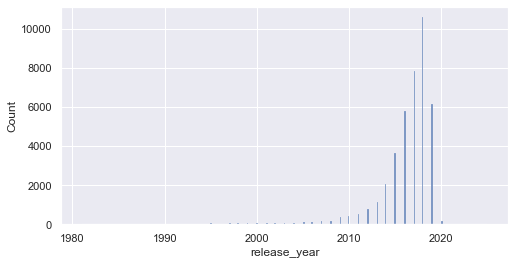

In [29]:
sns.histplot(df['release_year'])

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40817 entries, 0 to 40832
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          40817 non-null  object 
 1   developer     40817 non-null  object 
 2   achievements  40817 non-null  float64
 3   num_reviews   40817 non-null  float64
 4   multiplayer   40817 non-null  bool   
 5   mature        40817 non-null  bool   
 6   price         40817 non-null  float64
 7   percent_pos   40817 non-null  int32  
 8   release_year  40817 non-null  int32  
dtypes: bool(2), float64(3), int32(2), object(2)
memory usage: 2.3+ MB


In [31]:
df.head()

,name,developer,achievements,num_reviews,multiplayer,mature,price,percent_pos,release_year
0,DOOM,id Software,54.0,42550.0,True,False,19.99,92,2016
1,PLAYERUNKNOWN'S BATTLEGROUNDS,PUBG Corporation,37.0,836608.0,True,True,29.99,49,2017
2,BATTLETECH,Harebrained Schemes,128.0,7030.0,True,False,39.99,71,2018
3,DayZ,Bohemia Interactive,0.0,167115.0,True,False,44.99,61,2018
4,EVE Online,CCP,0.0,11481.0,True,False,0.00,74,2003


* Will remove "name"
* Will remove "developer"
* Will encode "multiplayer" and "mature" to "True" or "False" to 1 or 0

C:\Users\Luis Andres\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='num_reviews'>

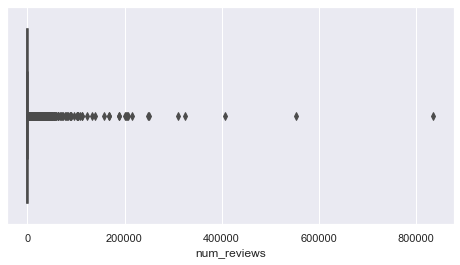

In [32]:
sns.boxplot(df["num_reviews"])

In [33]:
dropped = df.copy()
dropped.drop(columns=["name","developer"], inplace=True)

In [3]:
achivements = dropped
achivements["achievements"] = achivements["achievements"].map(lambda x: 0 if x == 0 else x)
achivements["achievements"].value_counts()

NameError: name 'dropped' is not defined

In [36]:
def review(x):
    if x == 0:
        return "no reviews"
    elif (x > 0) & (x < 20000):
        return "popular"
    elif (x >= 20000) & (x < 40000):
        return "very popular"
    elif x > 40000:
        return "top"
    else:
        return ValueError

def released(x):
    if x < 2000:
        return "retro"
    elif (x >= 2000) & (x < 2018):
        return "old"
    else:
        return "recent/new"

def per_pos(x):
    if x >= 90:
        return "A"
    elif (x >= 80) & (x < 90):
        return "B"
    elif (x >= 70) & (x < 80):
        return "C"
    elif (x >= 60) & (x < 70):
        return "D"
    elif x == 0:
        return "No eval"
    else:
        return "F"

no reviews      23454
popular         17169
very popular      116
top                78
Name: num_reviews, dtype: int64

In [39]:
achivements["multiplayer"] = achivements["multiplayer"].astype(int)
achivements["mature"] = achivements["mature"].astype(int)

clean_df = achivements.copy()

### 4. EDA (Exploratory Data Analysis)

In [42]:
df.describe()

,achievements,multiplayer,mature,price,num_reviews_no reviews,num_reviews_popular,num_reviews_top,num_reviews_very popular,percent_pos_A,percent_pos_B,percent_pos_C,percent_pos_D,percent_pos_F,percent_pos_No eval,release_year_old,release_year_recent/new,release_year_retro,price
count,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000,40817.000000
mean,0.298748,0.271431,0.070975,12.276223,0.574614,0.420634,0.001911,0.002842,0.104809,0.101257,0.081118,0.058579,0.079256,0.574981,0.574957,0.415636,0.009408,12.276223
std,0.457715,0.444703,0.256787,44.739483,0.494408,0.493667,0.043673,0.053235,0.306311,0.301672,0.273020,0.234837,0.270142,0.494352,0.494356,0.492837,0.096538,44.739483
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.990000
50%,0.000000,0.000000,0.000000,4.990000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.990000
75%,1.000000,1.000000,0.000000,9.990000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,9.990000
max,1.000000,1.000000,1.000000,999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,999.000000


<AxesSubplot:>

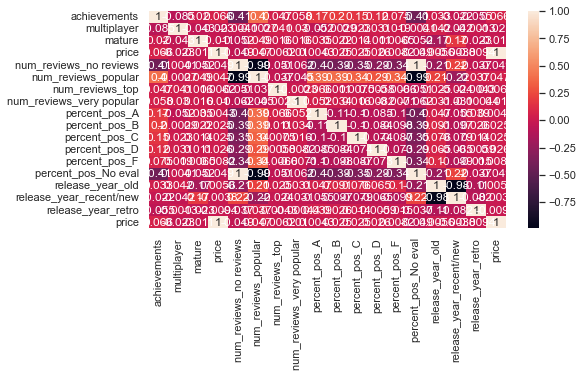

In [43]:
sns.heatmap(clean_df.corr(), annot=True)

## Modeling

In [44]:
from sklearn.cluster import KMeans

k = 5 # The number of clusters that you want to find

kmeans = KMeans(n_clusters=k)

y_pred = kmeans.fit_predict(clean_df) # Assigns each instance to a group from 0-4
y_pred

array([0, 0, 0, ..., 0, 0, 0])

### Testing the number of Clusters

In [45]:
inertias = [KMeans(n_clusters=i, max_iter= 300).fit(ohe_data).inertia_ for i in range(1,11)]
inertias

[81783669.69442602,
 15636517.891191803,
 7500180.637420641,
 4534758.594462321,
 3173460.354053821,
 2212239.662435235,
 1616423.8340442986,
 1277524.8483561696,
 1005823.8397814764,
 738613.4456257531]

Text(0, 0.5, 'Inertias')

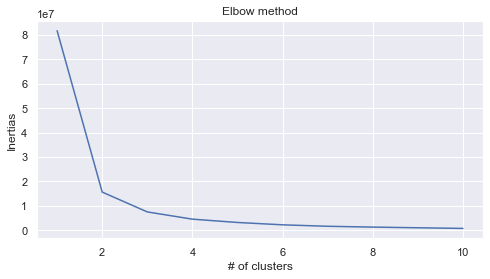

In [46]:
import matplotlib.pyplot as plt

plt.plot(range(1,11), inertias)
plt.title("Elbow method")
plt.xlabel("# of clusters")
plt.ylabel("Inertias")

There is a clear elbow in k=2

In [47]:
inertias = []
sil_scores = []

total_range = range(2,11) # silhouette score can't work with just 1 cluster, so start in 2

for i in total_range:
    print(i)
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(ohe_data)
    sil_scores.append(silhouette_score(ohe_data, kmeans.labels_))
    # Choosing the optimal number of clusters
    inertias.append(kmeans.inertia_)

2
3
4
5
6
7
8
9
10


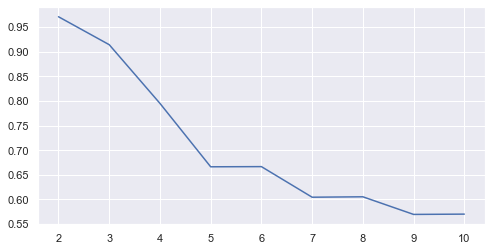

In [48]:
# Let's keep n_clusters in 2
plt.plot(total_range, sil_scores)

### K-Means method applied

In [49]:
kmeans = KMeans(n_clusters=2, max_iter = 300)
kmeans.fit(ohe_data)

# sil_scores.append(silhouette_score(ohe_data, kmeans.labels_))
# inertias.append(kmeans.inertia_)

KMeans(n_clusters=2)

In [50]:
ohe_data["Kmeans_cluster"] = kmeans.labels_
ohe_data.head()

,achievements,multiplayer,mature,price,num_reviews_no reviews,num_reviews_popular,num_reviews_top,num_reviews_very popular,percent_pos_A,percent_pos_B,percent_pos_C,percent_pos_D,percent_pos_F,percent_pos_No eval,release_year_old,release_year_recent/new,release_year_retro,Kmeans_cluster
0,1,1,0,19.99,0,0,1,0,1,0,0,0,0,0,1,0,0,0
1,1,1,1,29.99,0,0,1,0,0,0,0,0,1,0,1,0,0,0
2,1,1,0,39.99,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,0,1,0,44.99,0,0,1,0,0,0,0,1,0,0,0,1,0,0
4,0,1,0,0.00,0,1,0,0,0,0,1,0,0,0,1,0,0,0


In [51]:
y_pred = kmeans.fit_predict(ohe_data)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [52]:
# In order to visualize the cluster let's use the PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(ohe_data)
X2D

array([[ 7.71449321, -0.80532084],
       [17.71442971, -0.76552264],
       [27.71498464, -0.80761259],
       ...,
       [-4.28737188,  1.02494517],
       [-2.28714558,  1.02860946],
       [-7.28713469,  1.02338639]])

In [53]:
x_points = []
y_points = []

for point in X2D:
    x_points.append(point[0])
    y_points.append(point[1])

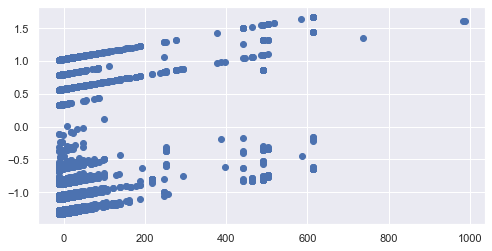

In [54]:
plt.scatter(x_points, y_points)

In [55]:
X2D_df = pd.DataFrame(data= X2D, columns= ["Component_1", "Component_2"])
X2D_final = pd.concat([X2D_df, ohe_data[["Kmeans_cluster"]]], axis=1)
X2D_final.dropna(inplace=True)
X2D_final

,Component_1,Component_2,Kmeans_cluster
0,7.714493,-0.805321,0.0
1,17.714430,-0.765523,0.0
2,27.714985,-0.807613,0.0
3,32.713764,-0.032824,0.0
4,-12.275503,-1.074180,0.0
...,...,...,...
40812,-9.287130,1.021297,0.0
40813,-9.287130,1.021297,0.0
40814,-4.287372,1.024945,0.0
40815,-2.287146,1.028609,0.0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

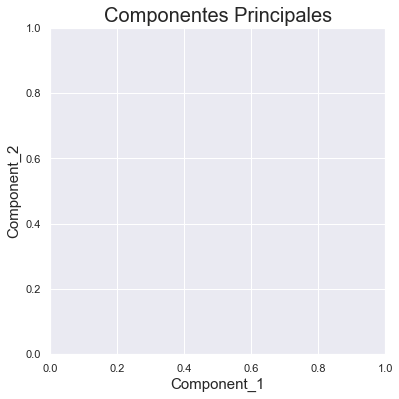

In [56]:
fig = plt.figure(figsize= (6,6))

ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Component_1', fontsize = 15)
ax.set_ylabel('Component_2', fontsize = 15)
ax.set_title('Componentes Principales', fontsize = 20)

color_theme = np.array(["blue", "green", "orange"])
ax.scatter(x = X2D_final.Component_1, y = X2D_final.Component_2, 
            c = color_theme[X2D_final], s = 50)

Centroid initialization method